In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [54]:
rng = np.random.RandomState(20170720)
data = pd.read_csv('data.csv')

n_bootstrap = 1000
repetitions = 100

In [55]:
state_black = data['Fraction Black'].values
state_woman = data['Fraction Female'].values

In [56]:
for ii in range(repetitions):
    senate_woman = rng.rand(n_bootstrap, 50, 2) < state_woman[np.newaxis, :, np.newaxis]
    senate_black = rng.rand(n_bootstrap, 50, 2) < state_black[np.newaxis, :, np.newaxis]
    both_women_per_state = senate_woman[..., 0] * senate_woman[..., 1]
    if ii == 0:
        n_states_2_women = both_women_per_state.sum(axis=1)
        n_black_women = np.sum(senate_woman * senate_black, axis=(1, 2))
        n_black = senate_black.sum(axis=(1, 2))
        n_women = senate_woman.sum(axis=(1, 2))
    else:
        n_states_2_women = np.concatenate([n_states_2_women, both_women_per_state.sum(axis=1)])
        n_black_women = np.concatenate([n_black_women, np.sum(senate_woman * senate_black, axis=(1, 2))])
        n_black = np.concatenate([n_black, senate_black.sum(axis=(1, 2))])
        n_women = np.concatenate([n_women, senate_woman.sum(axis=(1, 2))])

In [98]:
def make_plots(data, reality, description):
    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        h, b, p = ax.hist(data, bins=np.arange(0, 101), normed=True)
        ax.plot([reality + .5, reality + .5], [0, 1], c='black')
        ax.set_ylim(h[h>0].min()/10., 1)
        ax.set_xlim(-1, data.max() + 2)
        ax.set_xlabel('Number')
        ax.set_ylabel('Probability')
    axes[0].set_ylim(0, 1)
    axes[1].set_yscale('log')
    plt.show()
    print('p for {} or fewer {}: {}'.format(reality, description, np.mean(data <= reality)))
    print('mean for {}: {}'.format(description, data.mean()))
    print('mode for {}: {} at {} probability'.format(description, h.argmax(), h.max()))

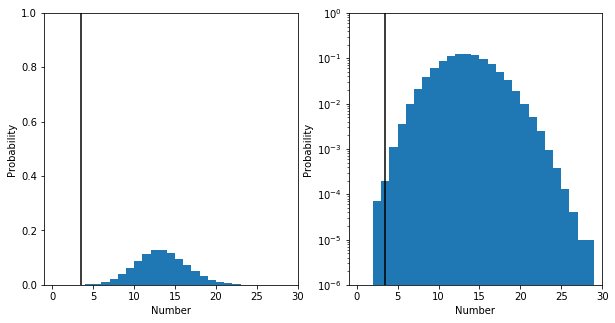

p for 3 or fewer states with 2 women senators: 0.00027
mean for states with 2 women senators: 12.86935
mode for states with 2 women senators: 13 at 0.12691 probability


In [99]:
make_plots(n_states_2_women, 3, 'states with 2 women senators')

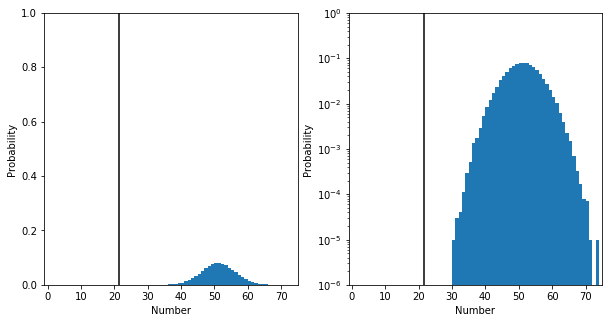

p for 21 or fewer women senators: 0.0
mean for women senators: 50.7192
mode for women senators: 51 at 0.08075 probability


In [100]:
make_plots(n_women, 21, 'women senators')

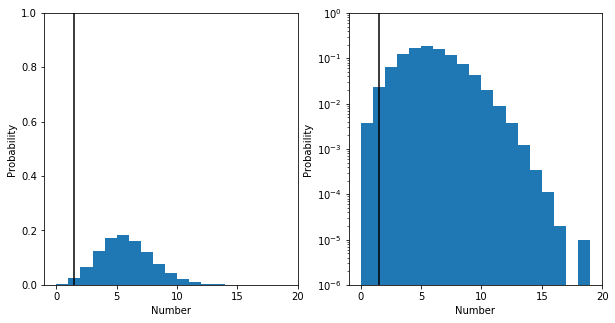

p for 1 or fewer Black women senators: 0.02698
mean for Black women senators: 5.26046
mode for Black women senators: 5 at 0.18222 probability


In [101]:
make_plots(n_black_women, 1, 'Black women senators')

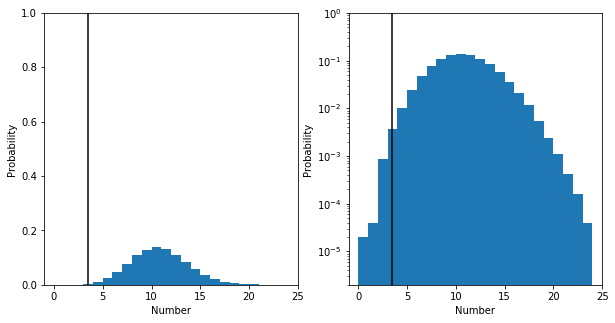

p for 3 or fewer Black senators: 0.00457
mean for Black senators: 10.31711
mode for Black senators: 10 at 0.1378 probability


In [102]:
make_plots(n_black, 3, 'Black senators')

# Coins 

In [40]:
def factorial(n):
    """Compute n!."""
    result = 1
    for ii in range(1, n+1):
        result *= ii
    return result

def odds(n, h):
    """Compute the odds of getting h heads in n coin-flips."""
    return .5**n * (factorial(n))/(factorial(n-h))/(factorial(h))

In [50]:
print(odds(10, 5))
print(odds(10, 7))

0.24609375
0.1171875


In [51]:
print(odds(100, 50))
print(odds(100, 70))

0.07958923738717878
2.3170690580135177e-05


In [52]:
(factorial(100))/(factorial(100-21))/(factorial(21))

2.0418414110621324e+21